In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from river import evaluate
from river import metrics

from river import stream, compose, drift
from river import preprocessing
from river import linear_model as ln
%matplotlib inline

In [2]:
#Loading the dataset
data= pd.read_csv("/Users/promisea/Auto_Online_Datasets/wustl-scada-2018.csv")

In [3]:
data

,Sport,TotPkts,TotBytes,SrcPkts,DstPkts,SrcBytes,Target
0,143,2,180,2,0,180,0
1,68,2,684,2,0,684,0
2,0,1,60,1,0,60,0
3,54949,10,628,4,6,248,0
4,54943,8,496,4,4,248,0
...,...,...,...,...,...,...,...
7037978,49317,14,904,8,6,520,0
7037979,49318,14,904,8,6,520,0
7037980,49319,12,780,8,4,520,0
7037981,49320,12,780,8,4,520,0


In [4]:
print('Original dataset shape %s' % Counter(data['Target']))

Original dataset shape Counter({0: 6634581, 1: 403402})


In [5]:
normal_drop = data[data['Target'] == 0]

In [6]:
attack_drop = data[data['Target'] == 1]

In [7]:
attack_to_remove = attack_drop[:353402]

In [8]:
normal_to_remove = normal_drop[:6584581]

In [9]:
data = data.drop(normal_to_remove.index)

In [10]:
data = data.drop(attack_to_remove.index)

In [11]:
data.shape

(100000, 7)

In [12]:
data.to_csv('scada_modified.csv', index=False)

In [13]:
X = data.drop(['Target'], axis=1)
y = data['Target']

In [14]:
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({1: 50000, 0: 50000})


In [15]:
X, y = shuffle(X, y, random_state=42)

In [16]:
dataset = stream.iter_pandas(X, y)

In [17]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier(alpha=0.1, B=4.6)
)

In [18]:
dataset = stream.iter_pandas(X, y)

In [19]:
#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [20]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

[50,000]            Precision   Recall   F1       Support  
                                                  
       0      97.12%   98.84%   97.97%     24966  
       1      98.82%   97.07%   97.94%     25034  
                                                  
   Macro      97.97%   97.96%   97.96%            
   Micro      97.96%   97.96%   97.96%            
Weighted      97.97%   97.96%   97.96%            

                 97.96% accuracy                   – 00:00:01 – 4.24 KB
[100,000]            Precision   Recall   F1       Support  
                                                  
       0      96.93%   98.78%   97.84%     50000  
       1      98.75%   96.87%   97.80%     50000  
                                                  
   Macro      97.84%   97.82%   97.82%            
   Micro      97.82%   97.82%   97.82%            
Weighted      97.84%   97.82%   97.82%            

                 97.82% accuracy                   – 00:00:02 – 4.24 KB
CPU times: user 2.7

           Precision   Recall   F1       Support  
                                                  
       0      96.93%   98.78%   97.84%     50000  
       1      98.75%   96.87%   97.80%     50000  
                                                  
   Macro      97.84%   97.82%   97.82%            
   Micro      97.82%   97.82%   97.82%            
Weighted      97.84%   97.82%   97.82%            

                 97.82% accuracy                  

In [21]:
dataset = stream.iter_pandas(X, y)

In [22]:
def plot_performance(dataset, metric, models):
    metric_name = metric.__class__.__name__
    
    # Creating a single plot for accuracy
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    threshold_reached_step = None  # To store the step where accuracy reaches 75%

    for model_name, model in models.items():
        steps = []
        accuracies = []

        for checkpoint in evaluate.iter_progressive_val_score(
            dataset, model, metric, measure_time=False, measure_memory=False, step=100
        ):
            current_step = checkpoint["Step"]
            current_accuracy = checkpoint[metric_name].get()
            steps.append(current_step)
            accuracies.append(current_accuracy)

            # Check if the accuracy reaches 75% for the first time
            if current_accuracy >= 0.75 and threshold_reached_step is None:
                threshold_reached_step = current_step

        ax.plot(steps, accuracies, label=model_name)

        # Draw a vertical red line and annotate if the threshold is reached
        if threshold_reached_step:
            ax.axvline(x=threshold_reached_step, color='red', linestyle='--')
            ax.annotate(f'{threshold_reached_step} samples', xy=(threshold_reached_step, 0.75),
                        xytext=(threshold_reached_step + 50, 0.80),
                        arrowprops=dict(facecolor='blue', shrink=0.05),
                        horizontalalignment='left', verticalalignment='top')

    ax.set_ylabel('Accuracy', fontweight='bold')
    ax.set_xlabel('# Samples', fontweight='bold')
    ax.grid(True)
    ax.legend(
        loc='upper center', bbox_to_anchor=(0.5, 1.15),
        ncol=1, fancybox=True, shadow=True
    )
    
    # Apply bold formatting directly to tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig('Performance_ALMA_SCADA.png')
    plt.close()

    return fig

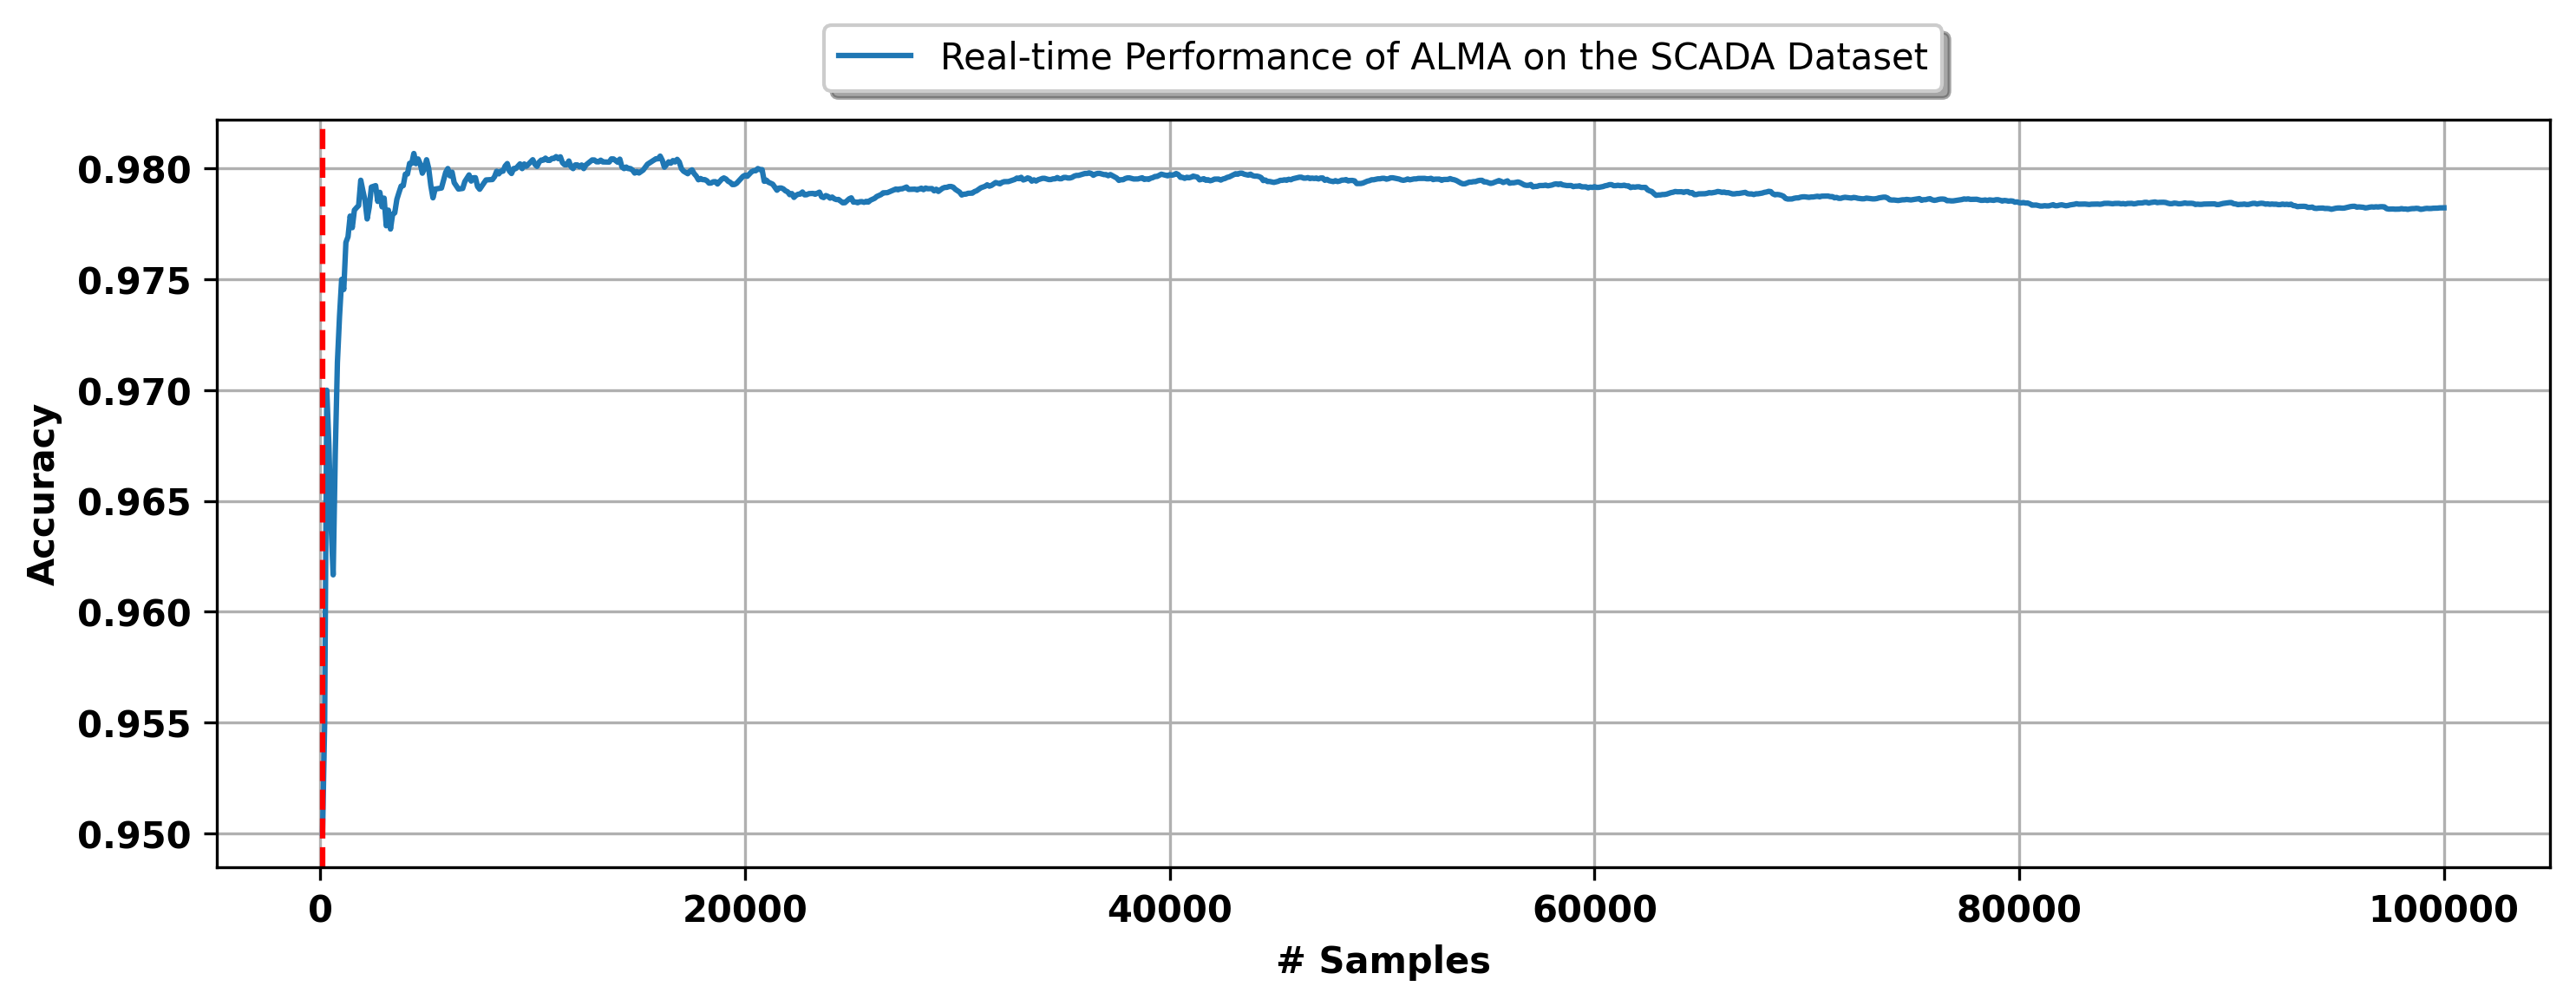

In [23]:
plot_performance(
    dataset,
    metrics.Accuracy(),
    {
        "Real-time Performance of ALMA on the SCADA Dataset": (
            preprocessing.StandardScaler() |ln.ALMAClassifier(alpha=0.1, B=4.6)
        )
    }
)

In [24]:
#Loading the dataset
data= pd.read_csv("scada_modified.csv")
print('Original dataset shape  %s' % Counter(data['Target']))
X = data.drop(['Target'], axis=1)
y = data['Target']
X, y = shuffle(X, y, random_state=42)

Original dataset shape  Counter({1: 50000, 0: 50000})


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=100, stratify=data['Target'])


model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier(alpha=0.1, B=4.6)
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [26]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

CPU times: user 140 ms, sys: 1.42 ms, total: 142 ms
Wall time: 141 ms


           Precision   Recall   F1       Support  
                                                  
       0      96.15%   99.06%   97.58%      2447  
       1      99.07%   96.20%   97.62%      2553  
                                                  
   Macro      97.61%   97.63%   97.60%            
   Micro      97.60%   97.60%   97.60%            
Weighted      97.64%   97.60%   97.60%            

                 97.60% accuracy                  

In [27]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 95% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 95% unseen samples
Accuracy: 0.9849263157894736
Precision: 0.9993272131432168
Recall: 0.9704723164794402
F1_Score: 0.9846884222231728


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=100, stratify=data['Target'])


model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier(alpha=0.1, B=4.6)
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [29]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

CPU times: user 304 ms, sys: 13.8 ms, total: 318 ms
Wall time: 310 ms


           Precision   Recall   F1       Support  
                                                  
       0      84.28%   87.79%   86.00%      4978  
       1      87.37%   83.77%   85.53%      5022  
                                                  
   Macro      85.83%   85.78%   85.77%            
   Micro      85.77%   85.77%   85.77%            
Weighted      85.83%   85.77%   85.77%            

                 85.77% accuracy                  

In [30]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 90% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 90% unseen samples
Accuracy: 0.9702222222222222
Precision: 0.9737891482593306
Recall: 0.9664280314820579
F1_Score: 0.97009462595965


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=100, stratify=data['Target'])


model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier(alpha=0.1, B=4.6)
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [32]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

CPU times: user 444 ms, sys: 14.1 ms, total: 458 ms
Wall time: 446 ms


           Precision   Recall   F1       Support  
                                                  
       0      89.98%   92.43%   91.19%      7521  
       1      92.18%   89.65%   90.90%      7479  
                                                  
   Macro      91.08%   91.04%   91.04%            
   Micro      91.05%   91.05%   91.05%            
Weighted      91.08%   91.05%   91.04%            

                 91.05% accuracy                  

In [33]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 85% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 85% unseen samples
Accuracy: 0.9847058823529412
Precision: 0.9924262334249193
Recall: 0.9768820112415042
F1_Score: 0.9845927751967385
